# Fine tuning state of the art models for the home made dataset

The goal of this notebook is to have a good model on a simpler model :

* instead of using all the classes from the whole dataset, we grouped labels in 5 groups
* instead of designing our own CNN, we decided to use state of the hard models

## Librairies

In [ ]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import pickle

In [ ]:
# Set a big font size
plt.rcParams.update({'font.size': 20})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save folders
save_path = '/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/FINAUX/saves/'
best_backbone = 'resnet'
training = False

## Loading the data

As we saw in the notebook `New data - First bad model`, a grouping of similar letters is needed if we want to achieve acceptable results. After some experimentations, it is the same with fine-tuned model. So we keep this methodology. We first load the data:

In [ ]:
# Unzip the data
!rm -rf data_new_grouped
!unzip '/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/new_data_filtered_splitted_grouped_v3.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/new_data_filtered_splitted_grouped_v3.zip
   creating: data_new_grouped/
   creating: data_new_grouped/test/
   creating: data_new_grouped/test/COF/
  inflating: data_new_grouped/test/COF/Léa_C_136.jpg  
  inflating: data_new_grouped/test/COF/Léa_O_100.jpg  
  inflating: data_new_grouped/test/COF/Léa_O_88.jpg  
  inflating: data_new_grouped/test/COF/AAG_F_84.jpg  
  inflating: data_new_grouped/test/COF/Léa_C_128.jpg  
  inflating: data_new_grouped/test/COF/Maryline_F_56.jpg  
  inflating: data_new_grouped/test/COF/Charles_F_44.jpg  
  inflating: data_new_grouped/test/COF/Maryline_F_92.jpg  
  inflating: data_new_grouped/test/COF/Charles_F_56.jpg  
  inflating: data_new_grouped/test/COF/Léa_C_160.jpg  
  inflating: data_new_grouped/test/COF/Maryline_F_64.jpg  
  inflating: data_new_grouped/test/COF/Chong_C_52.jpg  
  inflating: data_new_grouped/test/COF/Olivier_C_84.jpg  
  inflating: data_new_grouped/test/COF/AAG_F

Let's recall the grouping we have chosen:

In [ ]:
!ls data_new_grouped/train/

AEIMNS	B  COF	DKRU  GHT  L  P  Q  V  W  X  Y


We remove the singletons:

In [ ]:
# Remove little classes
!rm -rf data_new_grouped/train/B/ data_new_grouped/test/B/
!rm -rf data_new_grouped/train/L/ data_new_grouped/test/L/
!rm -rf data_new_grouped/train/P/ data_new_grouped/test/P/
!rm -rf data_new_grouped/train/Q/ data_new_grouped/test/Q/
!rm -rf data_new_grouped/train/V/ data_new_grouped/test/V/
!rm -rf data_new_grouped/train/W/ data_new_grouped/test/W/
!rm -rf data_new_grouped/train/X/ data_new_grouped/test/X/
!rm -rf data_new_grouped/train/Y/ data_new_grouped/test/Y/

This following function will build the `ImageDataGenerator`s based on the preprocessing requiered by the network.

In [ ]:
# Function to build data generators
def build_generator(preprocess_input_f):

  # Build the ImageDataGenerator 
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      zoom_range=0.2,
      preprocessing_function=preprocess_input_f
  )
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=preprocess_input_f
  )

  # Build the data loads
  training_generator = train_datagen.flow_from_directory(
      'data_new_grouped/train/',
      target_size=(img_width, img_height),
      batch_size=64,
      class_mode='categorical',
      shuffle=True
  )
  test_generator = test_datagen.flow_from_directory(
      'data_new_grouped/test/',
      target_size=(img_width, img_height),
      batch_size=64,
      class_mode='categorical',
      shuffle=False
  )

  return training_generator, test_generator

## Fine tuning

Now we decide to compare 5 pretrained models which are known to perform well on such classification task:


*   DenseNet201 ([Densely Connected Convolutional Networks (CVPR 2017)](https://arxiv.org/abs/1608.06993))
*   Resnet50 ([Deep Residual Learning for Image Recognition (CVPR 2015)](https://arxiv.org/abs/1512.03385))
*   EfficientNetV2B3 ([EfficientNetV2: Smaller Models and Faster Training (ICML 2021)](https://arxiv.org/abs/2104.00298))
*   InceptionV3 ([Rethinking the Inception Architecture for Computer Vision (CVPR 2016)](http://arxiv.org/abs/1512.00567))
*   VGG16 ([Very Deep Convolutional Networks for Large-Scale Image Recognition (ICLR 2015)](https://arxiv.org/abs/1409.1556))



In [ ]:
# Input width, height
img_width, img_height = 224, 224

The networks are loaded without their last layer and then set as non-trainable.

In [ ]:
# Extract a model to finetune
def createBackboneModel(net='vgg'):
  # Load a pretrained model
  if net == 'dense': 
    backbone = tf.keras.applications.densenet.DenseNet201(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=(img_width, img_height, 3))
    preprocess_input_f = tf.keras.applications.densenet.preprocess_input
  elif net == 'resnet':
    backbone = tf.keras.applications.resnet50.ResNet50(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=(img_width, img_height, 3))
    preprocess_input_f = tf.keras.applications.resnet50.preprocess_input
  elif net == 'efficient':
    backbone = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=(img_width, img_height, 3),
                                                          include_preprocessing=False)
    preprocess_input_f = tf.keras.applications.efficientnet_v2.preprocess_input
  elif net == 'inception':
    backbone = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=(img_width, img_height, 3))
    preprocess_input_f = tf.keras.applications.inception_v3.preprocess_input
  else:
    backbone = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=(img_width, img_height, 3))
    preprocess_input_f = tf.keras.applications.vgg16.preprocess_input

  # Cut of the top    
  output = backbone.layers[-1].output
  output = tf.keras.layers.Flatten()(output)
  backboneModel = tf.keras.models.Model(backbone.input, outputs=output)
  # Freeze the weights
  for layer in backboneModel.layers:
      layer.trainable = False
  # Return the model and its preprocessing function
  return backboneModel, preprocess_input_f

We fine tuned all the networks (see [learning curves](#learning_curves)):

In [ ]:
# Load the backbone model
backbone_model, preprocess_input_f = createBackboneModel(net=best_backbone)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# Build the generators
training_generator, test_generator = build_generator(preprocess_input_f)

Found 2325 images belonging to 4 classes.
Found 564 images belonging to 4 classes.


In [ ]:
# Build and save the reverse dictionnary for outputs
class_indices_rev = { v : k for k,v in training_generator.class_indices.items() }
with open(save_path + 'finetuning_class_indices_rev.pkl', 'wb') as f:
  pickle.dump(class_indices_rev, f)

In [ ]:
# Get the number of classes
n_classes = len(training_generator.class_indices)

For that purpuse, we decided to add at the top of each pretrained network :


1.   A Dropout layer
2.   A Dense layer of size dense=512, with ReLU activation
3.   A Dropout layer
4.   A final layer of size n_classes with softmax activation for the prediction



In [ ]:
# Create a new model from the backbone model
def createModel(backbone, lr=1e-4, dense=512, dropout1=0.5, dropout2=0.25):
  # Build the model
  model = tf.keras.models.Sequential()
  model.add(backbone)
  model.add(tf.keras.layers.Dropout(dropout1))
  model.add(tf.keras.layers.Dense(dense, activation='relu'))
  model.add(tf.keras.layers.Dropout(dropout2))
  model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
  # Compile the model
  model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Nadam(learning_rate=lr),
    metrics=['accuracy']
  )
  return model

In [ ]:
# Learning scheduler
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.2, min_lr=1e-7)

In [ ]:
# Build the final model
model = createModel(backbone_model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 100352)            23587712  
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 74,970,500
Trainable params: 51,382,788
Non-trainable params: 23,587,712
_________________________________________________________________


We train the network for 25 epochs, 

In [ ]:
if training:
  # Checkpoint
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_path + 'finetuning_{}.h5'.format(best_backbone), save_weights_only=False,
                                                    monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  # Fit the model
  history = model.fit(training_generator, epochs=25, validation_data=test_generator, callbacks=[lr_callback, checkpoint])
  with open(save_path + 'finetuning_{}_history.pkl'.format(best_backbone), 'wb') as f:
     pickle.dump(history.history, f)
  history = history.history
else :
  # Load the model from saves
  model =  tf.keras.models.load_model(save_path + 'finetuning_{}.h5'.format(best_backbone))
  with open(save_path + 'finetuning_{}_history.pkl'.format(best_backbone), 'rb') as f:
    history = pickle.load(f)

For all the networks, the accuracy is very good on the training set (~99%). However, it has more difficulties on the validation set. For the best network (ResNet) the accuracy doesn't go over 70%... 

### Visualizing the learning curves <a class="anchor" id="learning_curves"></a>

After training 

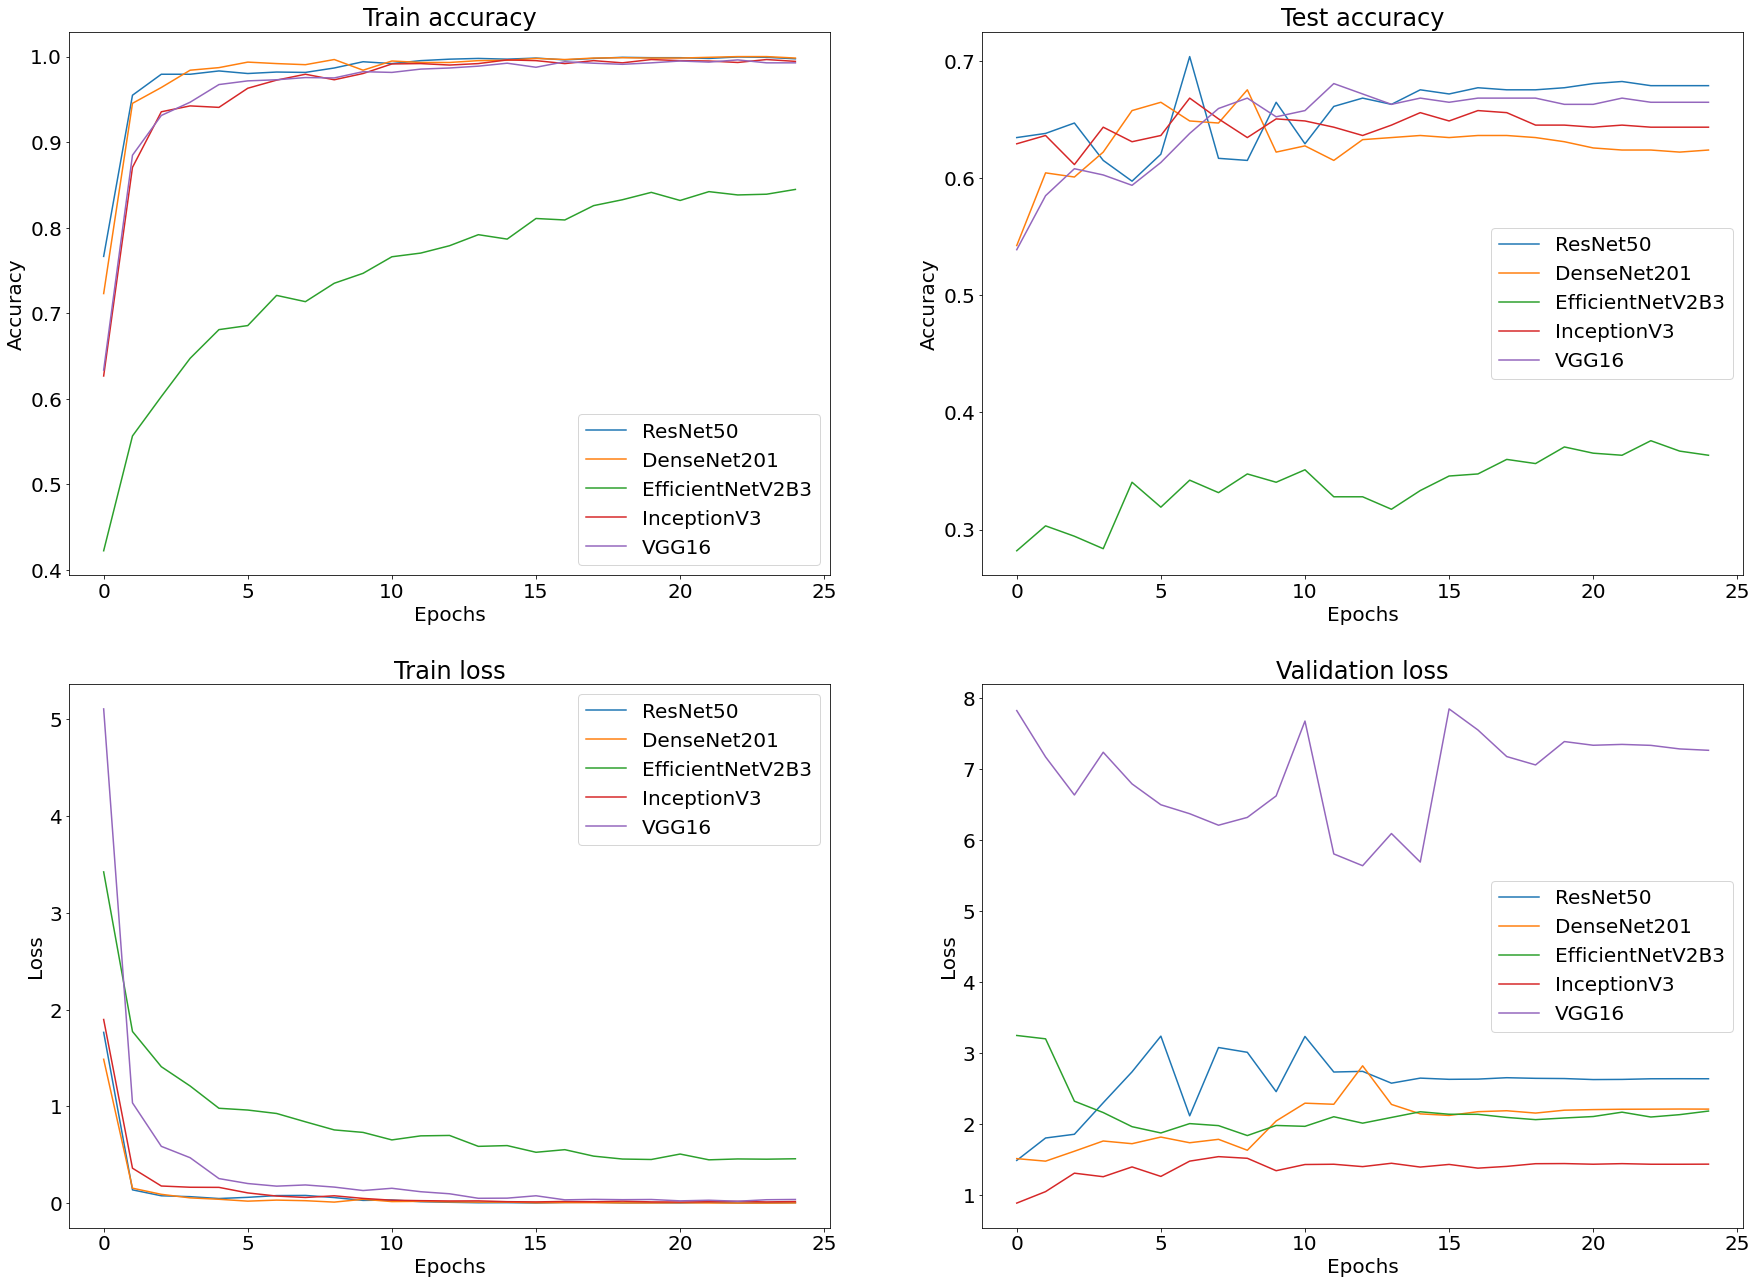

In [ ]:
# Plot the learning curves

# Load the data
files = {}
mapping = {
    'dense' : "DenseNet201",
    'resnet' : "ResNet50",
    'efficient' : "EfficientNetV2B3",
    'inception' : "InceptionV3",
    'vgg' : "VGG16"
}
for filepath in glob.glob(save_path + 'finetuning_*.pkl'):
  name = mapping[filepath.split('_')[1]]
  with open(filepath, 'rb') as f:
    files[name] = pickle.load(f)

# Display everything
plt.figure(figsize=(30,22), facecolor='white')
plt.subplot(2, 2, 1)
for name, hist in files.items():
  plt.plot(hist['accuracy'], label=name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy')
plt.legend()
plt.subplot(2, 2, 2)
for name, hist in files.items():
  plt.plot(hist['val_accuracy'], label=name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.legend()
plt.subplot(2, 2, 3)
for name, hist in files.items():
  plt.plot(hist['loss'], label=name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()
plt.subplot(2, 2, 4)
for name, hist in files.items():
  plt.plot(hist['val_loss'], label=name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.legend()
plt.show()

Despite using pretrained models, the accuracy on this home made dataset is still very bad compared to the MNIST dataset. It could be explained by the size of the dataset, the quality of the images or the preprocessing used.

## Confusion matrix

In [ ]:
# Make a prediction
from sklearn.metrics import accuracy_score

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=-1)
y_true = test_generator.classes
accuracy_score(y_true, y_pred)

0.7039007092198581

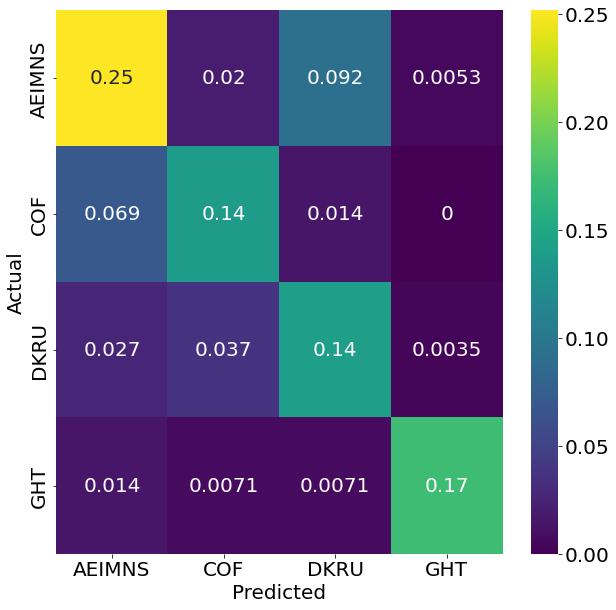

In [ ]:
# Make the confusion matrix
import pandas as pd
import seaborn as sns

## Build a dataframe
data = {
  'Actual labels': y_true,
  'Predicted labels': y_pred
}
reverse_class_idx = { v : k for k,v in test_generator.class_indices.items() }
axis_labels = reverse_class_idx.values()
df = pd.DataFrame(data, columns=['Actual labels','Predicted labels'])

## Compute the confusion matrix
confusion_matrix = pd.crosstab(df['Actual labels'], df['Predicted labels'], rownames=['Actual'], colnames=['Predicted'], normalize='all')

## Plot the heapmap
plt.figure(figsize=(10, 10), facecolor='white')
sns.heatmap(confusion_matrix, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, cmap='viridis')
plt.show()

The biggest group has the biggest score, which is logical since there are more samples in the dataset. Overall the network is efficient with this grouping.

## GradCam heatmaps

Let's visualize the heatmaps again:

In [ ]:
# Download vizgradcam
!git clone https://github.com/gkeechin/vizgradcam
!cp vizgradcam/gradcam.py .

Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), done.


102981632/102967424 [==============================] - 2s 0us/step


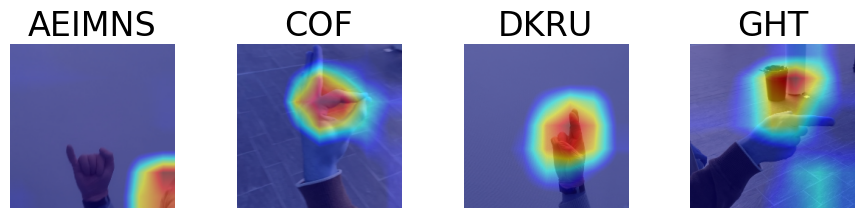

In [ ]:
# Visualize a few images

from gradcam import VizGradCAM
import cv2

dense_model = tf.keras.applications.resnet.ResNet50(weights='imagenet')

plt.figure(figsize=(20,10))
for i, label in reverse_class_idx.items():
  plt.subplot(4, 7, i+1)
  # Select an image
  idx = np.argmax(test_generator.classes == i)
  filename = '/content/data_new_grouped/test/' + test_generator.filenames[idx]
  im = cv2.imread(filename)
  im = cv2.resize(im, (img_width, img_height))
  im_p = preprocess_input_f(np.array(im))
  # Calculer Grad-CAM
  interpolant = 0.5
  cvt_heatmap = VizGradCAM(dense_model, im_p, plot_results=False, interpolant=interpolant)
  plt.imshow(np.uint8(im * interpolant + cvt_heatmap * (1 - interpolant)))
  plt.axis('off')
  plt.title(label)
plt.show()

On these examples, the heatmap for COF and DKRU seems pretty coherent, unlike AEIMNS and GHT. It seems like the network has difficulties to deal with the textured background, or to detect the hand when it's too small on the picture.